In [1]:
import os
import time
import numpy as np
import pandas as pd

from skimage import io

import matplotlib.pyplot as plt

from CellMet.segmentation import Segmentation, create_skeleton
from CellMet.analysis import cell_analysis, edge_analysis, face_analysis

from CellMet.plot import random_color
from CellMet.image import colored_image_cell
import ZebrafishMuscle.plot as ZMplot
from CellMet.io import write_tiff


import plotly.graph_objects as go
%load_ext snakeviz

In [9]:


# path = "/home/u2175049/Documents/Code/CellMet/notebooks/"
# seg_filename = "artificial_tissue_150cells_5_to70cells.tif"
# pixel_size = dict(x_size = 0.21,
#                   y_size = 0.21,
#                   z_size = 0.5,)

path = "/mnt/sda1/CellSegPaperDatas/Myotome_data/zf_mytome_data/"
seg_filename = "new_mask_v2.tif"

# path = "/mnt/sda1/Sophie/7-DosophilaEmbryo/T20/"
# seg_filename = "20161108-embPHcherry-t20_cp_masks.tif"
pixel_size = dict(x_size = 0.1071804,
                  y_size = 0.1071804,
                  z_size = 0.5,)

In [10]:
image = io.imread(os.path.join(path, seg_filename))


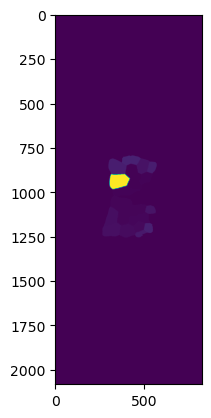

In [11]:
plt.imshow(image[50])

In [6]:
from skimage.measure import label, regionprops

for i in pd.unique(image.flatten())[1:]:
    print(i)
    tmp = image==i
    
    tmp_label = label(tmp)
    if len(np.unique(tmp_label))>2:
        print(i, np.unique(tmp_label))
        j = 1
        for region in regionprops(tmp_label):
            print(j, region.area)
            if region.area < 1305:
                pos_to_remove = np.where(tmp_label==j)
                image[pos_to_remove] = 0
            j+=1
    
    

9
10
12
1803
18
20
20 [0 1 2]
1 1057362.0
2 1.0
22
22 [0 1 2]
1 251277.0
2 1.0
26
26 [0 1 2 3]
1 1384273.0
2 1.0
3 1.0
27
27 [0 1 2 3]
1 669869.0
2 1.0
3 1.0
28
29
30
46
46 [0 1 2]
1 964637.0
2 1.0
51
70
72
90
94
120
143
144
159
164
164 [0 1 2]
1 1571943.0
2 1.0
172
172 [0 1 2 3]
1 1874064.0
2 1.0
3 1.0
206
207
208
225
225 [0 1 2]
1 1485278.0
2 1.0
252
254
278
294
297
306
352
359
359 [0 1 2]
1 1616606.0
2 1.0
372
426
433
437
437 [0 1 2 3]
1 681099.0
2 1.0
3 23.0
506
508
562
602
607
610
611
611 [0 1 2 3 4]
1 1246938.0
2 1.0
3 1.0
4 1.0
615
644
648
698
709
711
715
715 [0 1 2]
1 1095968.0
2 1.0
716
720
720 [0 1 2]
1 415276.0
2 1.0
736
760
793
828
868
868 [0 1 2 3]
1 687699.0
2 1.0
3 1.0
892
893
900
902
902 [0 1 2]
1 1559246.0
2 1.0
910
924
932
933
934
935
935 [0 1 2 3 4 5 6]
1 305079.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
941
941 [0 1 2]
1 148763.0
2 1.0
944
980
980 [0 1 2]
1 748924.0
2 1.0
996
1005
1011
1016
1016 [0 1 2]
1 712842.0
2 1.0
1021
1051
1051 [0 1 2]
1 1319804.0
2 1.0
1092
1093
1109
1

In [8]:

from tifffile import tifffile
tifffile.imwrite(os.path.join(path, 
                      "new_mask_v2.tif"),
         image.astype("uint16"),
         imagej=True,
         resolution=(1/pixel_size["x_size"], 1/pixel_size["y_size"]),
         metadata={
             'spacing': pixel_size["z_size"],
             'unit': 'um',
             'axes': 'ZYX',
             'hyperstack': True,
             'channels': 1,
             'slices': image.shape[1]
         })

In [12]:
seg = Segmentation(image, pixel_size, path, nb_core=2)

In [13]:
len(seg.unique_id_cells)

187

In [ ]:
# seg.perform_prerequisite(save_mesh=False, overwrite=True)


In [15]:
import sparse
from CellMet import image as csimage
def simplified_cell_analysis(seg):
    cell_df = pd.DataFrame(columns=["volume"])
    cell_df["id_im"] = seg.unique_id_cells
    for c_id in seg.unique_id_cells:
    
        sparse_cell = sparse.load_npz(os.path.join(seg.storage_path, "npz/" + str(c_id) + ".npz"))
        img_cell_dil = sparse_cell.todense()
        img_cell_dil[img_cell_dil == 2] = 1
        img_cell = csimage.get_label(sparse_cell.todense(), 1).astype("uint8")
        volume = (len(sparse_cell.coords[0]) * seg.voxel_size)
        cell_df.loc[cell_df[cell_df["id_im"]==c_id].index, "volume"] = volume
        cell_df.to_csv(os.path.join(seg.storage_path, "cell_df.csv"))
simplified_cell_analysis(seg)

In [7]:
cell_analysis(seg)

Cell analysis:   0%|          | 0/3979 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
cell_df = pd.read_csv(os.path.join(path,"cell_df.csv"), index_col=0)

In [24]:
cell_df[cell_df["volume"]>200]["volume"]

8       3338.008966
9       5524.991053
11      7037.757914
16      1879.027227
18      6477.448363
           ...     
3323     220.683273
3384     209.781504
3596     303.893979
3624     239.166882
3693     255.439122
Name: volume, Length: 187, dtype: float64

(array([3.005e+03, 3.240e+02, 1.090e+02, 6.500e+01, 4.700e+01, 3.300e+01,
        2.300e+01, 1.900e+01, 2.300e+01, 1.200e+01, 1.300e+01, 1.600e+01,
        1.200e+01, 3.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 2.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 4.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 <BarContainer object of 50 

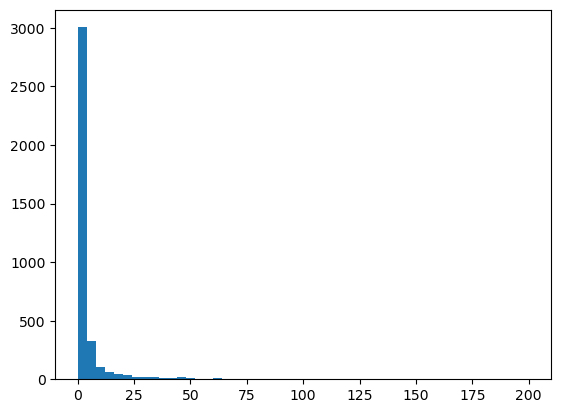

In [22]:
plt.hist(cell_df["volume"], bins=50, range=(0,200))

(array([61., 20.,  5.,  4.,  2.,  6.,  1.,  3.,  3.,  3.,  2.,  3.,  8.,
         7.,  3.,  4.,  7.,  6.,  5.,  3.,  3.,  1.,  5.,  5.,  3.,  2.,
         3.,  1.,  4.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  206.35244398,   536.84053551,   867.32862703,  1197.81671855,
         1528.30481007,  1858.79290159,  2189.28099312,  2519.76908464,
         2850.25717616,  3180.74526768,  3511.2333592 ,  3841.72145073,
         4172.20954225,  4502.69763377,  4833.18572529,  5163.67381682,
         5494.16190834,  5824.64999986,  6155.13809138,  6485.6261829 ,
         6816.11427443,  7146.60236595,  7477.09045747,  7807.57854899,
         8138.06664051,  8468.55473204,  8799.04282356,  9129.53091508,
         9460.0190066 ,  9790.50709812, 10120.99518965, 10451.48328117,
        10781.97137269, 11112.45946421, 11442.94755574, 11773.43564726,
        12103.92373878, 12434.4118303 , 12764.89992182, 13095.388013

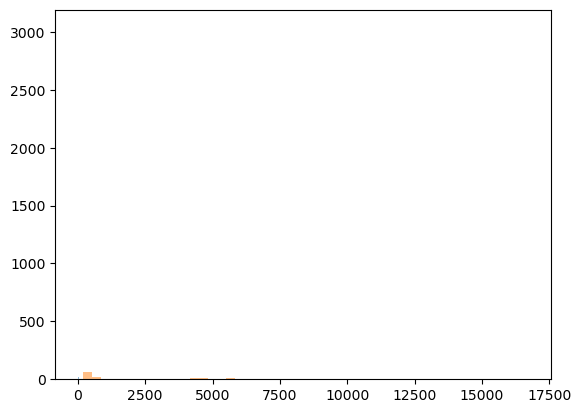

In [17]:
plt.hist(cell_df[cell_df["volume"]<200]["volume"], bins=50,  alpha=0.5)
plt.hist(cell_df[cell_df["volume"]>=200]["volume"], bins=50,  alpha=0.5)

In [25]:
# cell_df = cell_df[cell_df["volume"]>200]
new_img = np.zeros(image.shape)

pos = np.where(image>0)
new_img[pos] = 2

for i, row in cell_df[cell_df["volume"]>200].iterrows():
    pos = np.where(image==row["id_im"])
    new_img[pos] = row["id_im"]

In [27]:
from tifffile import tifffile
tifffile.imwrite(os.path.join(path, 
                      "new_mask.tif"),
         new_img.astype("uint16"),
         imagej=True,
         resolution=(1/0.4151329, 1/0.4151329),
         metadata={
             'spacing': 0.5711487,
             'unit': 'um',
             'axes': 'ZYX',
             'hyperstack': True,
             'channels': 1,
             'slices': new_img.shape[1]
         })

In [26]:
path

'/mnt/sda1/CellSegPaperDatas/Myotome_data/zf_mytome_data/'

In [14]:
seg.cell_segmentation()

Cell:   0%|          | 0/187 [00:00<?, ?it/s]

In [16]:
seg.edge_segmentation()


Cell:   0%|          | 0/187 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/66 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/78 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/66 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/91 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/55 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/120 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/78 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/91 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/55 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/78 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/105 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/55 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/1 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/55 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/55 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/136 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/66 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/78 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/1 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/171 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/66 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/78 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/78 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/105 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/45 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/105 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/105 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/1 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/1 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/1 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/55 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Edge segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
seg.face_segmentation()

Cell:   0%|          | 0/187 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/185 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/13 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/29 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/8 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/43 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/32 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/17 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/16 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/16 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/35 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/74 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/47 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/19 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/14 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/5 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/19 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/21 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/33 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/19 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/29 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/47 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/85 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/18 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/49 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/25 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/24 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/34 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/13 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/22 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/31 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/22 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/25 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/5 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/23 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/18 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/41 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/25 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/27 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/20 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/20 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/5 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/19 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/28 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/5 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/34 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/27 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/82 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/23 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/17 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/35 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/17 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/34 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/14 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/14 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/24 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/58 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/19 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/42 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/8 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/25 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/51 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/13 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/31 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/35 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/202 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/26 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/44 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/52 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/96 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/16 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/22 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/5 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/42 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/11 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/18 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/36 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/25 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/5 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/12 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/9 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/8 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/8 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/18 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/37 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/16 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/10 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/16 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/17 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/19 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/8 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/7 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/24 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/14 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/4 [00:00<?, ?it/s]

Face segmentation:   0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
print("ok")

ok


In [10]:
cell_analysis(seg)

In [11]:
edge_analysis(seg)

In [12]:
face_analysis(seg)

In [6]:
cell_df = pd.read_csv(os.path.join(path,"cell_df.csv"), index_col=0)
face_df = pd.read_csv(os.path.join(path,"face_df.csv"), index_col=0)
edge_df = pd.read_csv(os.path.join(path,"edge_df.csv"), index_col=0)

cell_plane_df = pd.read_csv(os.path.join(path,"cell_plane_df.csv"), index_col=0)

face_pixel_df = pd.read_csv(os.path.join(path,"face_pixel_df.csv"), index_col=0)
edge_pixel_df = pd.read_csv(os.path.join(path,"edge_pixel_df.csv"), index_col=0)

In [63]:
from CellMet.io import make_mesh_file
color_face_img = np.zeros(image.shape)

cell_id = 79

all_neighbours = np.unique(np.concatenate([face_pixel_df[face_pixel_df['id_im_1'] == cell_id]['id_im_2'].unique(),
                                           face_pixel_df[face_pixel_df['id_im_2'] == cell_id]['id_im_1'].unique()]))

# color_face_img[np.where(image==79)] = 1

i = 2
for im2 in all_neighbours:
    color_face_img = np.zeros(image.shape)
    sub_face = face_pixel_df[(face_pixel_df['id_im_2'] == cell_id) & (face_pixel_df['id_im_1'] == im2)]
    if len(sub_face) == 0:
        sub_face = face_pixel_df[(face_pixel_df['id_im_1'] == cell_id) & (face_pixel_df['id_im_2'] == im2)]
    color_face_img[sub_face['z'].to_numpy().astype(int),
                  sub_face['y'].to_numpy().astype(int),
                  sub_face['x'].to_numpy().astype(int)] = i

    i += 1
#     write_tiff(color_face_img, "cell_79_"+str(i),path, pixel_size)
    make_mesh_file(color_face_img, np.unique(color_face_img)[1:], meshtype="obj", path = path)

In [58]:
write_tiff(color_face_img, "cell_79",path, pixel_size)

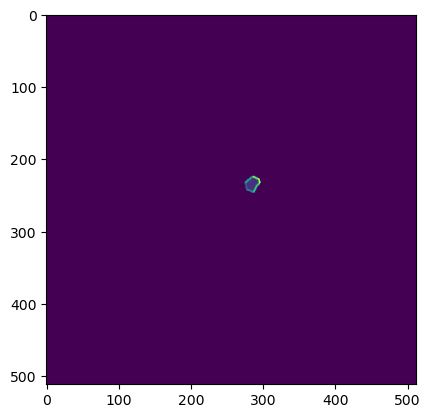

In [56]:
plt.imshow(color_face_img[12])

In [103]:
fig = go.Figure()

for c_id in [128]:
# c_id = 79 750
#     fig = ZMplot.draw_cell(image, c_id, fig=fig, **{"opacity":0.01})
    fig = ZMplot.draw_face(face_pixel_df, c_id, dict(x_size=1, y_size=1, z_size=1), 
                           fig=fig, 
                           **dict(size=5, marker_symbol="square",)
                          )
    
fig.update_layout(title='Cell center, edge position',
              autosize=False,
              width=900,
              height=900,
              margin=dict(l=65, r=50, b=65, t=90),
              showlegend=False,
#               scene = dict(
#                 aspectratio=dict(x=pixel_size["x_size"], 
#                                  y=pixel_size["y_size"], 
#                                  z=pixel_size["z_size"]),
#                 ),
              )
fig.update_traces(marker={'size': 5, "symbol":"square"})

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )

In [184]:
import scipy.linalg
fig = go.Figure()

for c_id in [128]:
    cell_id = c_id
    fig = ZMplot.draw_face(face_pixel_df, c_id, dict(x_size=1, y_size=1, z_size=1), 
                           fig=fig, 
                           **dict(size=5)
                          )
all_neighbours = np.unique(np.concatenate([face_pixel_df[face_pixel_df['id_im_1'] == cell_id]['id_im_2'].unique(),
                                               face_pixel_df[face_pixel_df['id_im_2'] == cell_id]['id_im_1'].unique()]))

for im2 in all_neighbours:
    sub_face = face_pixel_df[(face_pixel_df['id_im_2'] == cell_id) & (face_pixel_df['id_im_1'] == im2)]
    if len(sub_face) == 0:
        sub_face = face_pixel_df[(face_pixel_df['id_im_1'] == cell_id) & (face_pixel_df['id_im_2'] == im2)]

    data = sub_face[list("xyz")].to_numpy()

    ### https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6
    # regular grid covering the domain of the data
    X,Y = np.meshgrid(np.arange(data[:,0].min(), data[:,0].max(), 0.5), 
                      np.arange(data[:,1].min(), data[:,1].max(), 0.5))
    XX = X.flatten()
    YY = Y.flatten()


    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])

    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

    data = go.Surface(x=X, 
                      y=Y, 
                      z=Z, 
                      colorscale="Reds"
                     )

    fig.add_trace(data)
    scatter_data = go.Scatter3d(
                           x=sub_face['x'],
                            y=sub_face['y'],
                            z=sub_face['z'],
        mode="markers"
        )
#     fig.add_trace(scatter_data)

fig.update_layout(title='Cell center, edge position',
              autosize=False,
              width=900,
              height=900,
              margin=dict(l=65, r=50, b=65, t=90),
              showlegend=False,
#               scene = dict(
#                 aspectratio=dict(x=pixel_size["x_size"], 
#                                  y=pixel_size["y_size"], 
#                                  z=pixel_size["z_size"]),
#                 ),
              )
# fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )

In [185]:
C

array([ 6.51094724e+02, -3.80526643e+00, -5.62001411e-01, -2.12204333e-03,
        7.78059635e-03,  8.71734281e-04])

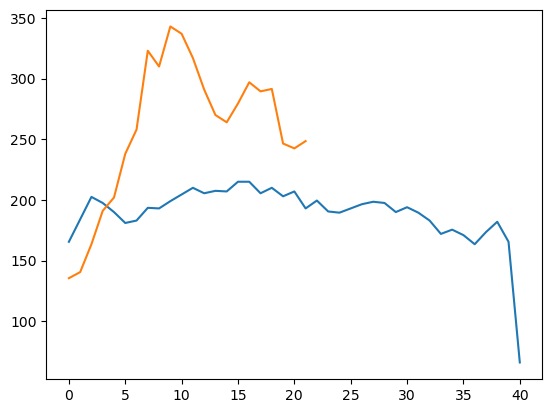

In [9]:
fig, ax = plt.subplots()
ax.plot(cell_plane_df[cell_plane_df["id_im"]==263]["z_center"]-np.min(cell_plane_df[cell_plane_df["id_im"]==263]["z_center"]),
         cell_plane_df[cell_plane_df["id_im"]==263]["area"])

ax.plot(cell_plane_df[cell_plane_df["id_im"]==750]["z_center"]-np.min(cell_plane_df[cell_plane_df["id_im"]==750]["z_center"]),
         cell_plane_df[cell_plane_df["id_im"]==750]["area"])

In [6]:
fig = go.Figure()

import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
color_list = get_colors(100)

i = 0
for c_id in cell_df["id_im"][:100]:

    # based on pixel in the image
    fig = ZMplot.draw_cell(image, c_id, fig=fig, **{"opacity":1, "color": color_list[i]})
    i+=1

# fig.update_layout(title='Cell center, edge position',
#               autosize=False,
#               width=900,
#               height=900,
#               margin=dict(l=65, r=50, b=65, t=90),
#               showlegend=False,
#               scene = dict(
#                 aspectratio=dict(x=1/pixel_size["x_size"], 
#                                  y=1/pixel_size["y_size"], 
#                                  z=1/pixel_size["z_size"]),
#                 ),
#               )

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )

NameError: name 'cell_df' is not defined

In [98]:
cell_df

id_im    x_center    y_center   z_center  nb_neighbor       volume  \
0        1  250.428935  216.374172  24.299669            6  1078.881328   
1        2  238.433816  244.521463  25.615183            6   985.472116   
2        3  233.384897  258.113797  24.129997            6  1028.780918   
3        4  245.760202  258.132116  24.238413            6  1070.908571   
4        5  251.836431  280.828200  24.274960            5  1019.922299   
..     ...         ...         ...        ...          ...          ...   
886    996  352.442149  300.739669  71.000000            4    31.300453   
887    997   83.039604  312.594059  71.000000            3    15.059652   
888    998   84.047170  324.783019  71.000000            3    15.748655   
889   1000  127.192677  364.184620  58.774809            7  1745.935316   
890   1003  114.644860  507.009346  71.000000            1    14.370648   

            area   real_dist  short_dist  curv_ind   orient_zy   orient_xy  \
0    1784.241204   26.907640   24.682950  0.082679   87.848576  -74.224419   
1    1591.204406   25.630371   23.578047  0.080074   94.879274 -121.890792   
2    1601.167595   24.811034   23.419516  0.056085   90.141847   97.190911   
3    1683.779042   25.829656   23.420332  0.093277   89.413990   63.434949   
4    1623.169639   27.497422   23.436155  0.147696   92.056485 -130.297945   
..           ...         ...         ...       ...         ...         ...   
886    31.550100    0.000000    0.000000       NaN    0.000000    0.000000   
887    21.586911    0.000000    0.000000       NaN    0.000000    0.000000   
888    22.417177    0.000000    0.000000       NaN    0.000000    0.000000   
889  2313.535652  431.282448   17.308100  0.959868  100.757967  103.335492   
890    16.190183    0.000000    0.000000       NaN    0.000000    0.000000   

     orient_xz     x_start     y_start  z_start       x_end       y_end  \
0    -7.574501  253.717949  216.384615      4.0  248.000000  218.000000   
1    -7.811932  243.625000  246.500000      5.0  238.000000  243.000000   
2     1.124126  233.195489  256.601504      5.0  234.000000  256.500000   
3     1.171898  245.161290  257.580645      5.0  246.000000  258.000000   
4    -2.424694  251.736111  282.472222      5.0  250.000000  281.000000   
..         ...         ...         ...      ...         ...         ...   
886   0.000000  352.452632  300.868421     71.0  352.452632  300.868421   
887   0.000000   83.112676  312.957746     71.0   83.112676  312.957746   
888   0.000000   84.175676  324.824324     71.0   84.175676  324.824324   
889  38.713516  119.160000  365.940000     45.0  140.000000  361.000000   
890   0.000000  115.036585  507.487805     71.0  115.036585  507.487805   

     z_end  sphericity  
0     47.0    0.285110  
1     46.0    0.300969  
2     46.0    0.307796  
3     46.0    0.300631  
4     46.0    0.301878  
..     ...         ...  
886   71.0    1.522359  
887   71.0    1.366166  
888   71.0    1.355394  
889   71.0    0.303082  
890   71.0    1.765563  

[891 rows x 20 columns]

In [7]:
import networkx as nx
G = nx.Graph()
for c, row in cell_df.iterrows():
    G.add_node(row["id_im"], pos=row[["x_center", "y_center"]].to_numpy(), neighbor = row["nb_neighbor"])
# G.add_nodes_from(cell_df["id_im"], pos=cell_df[["x_center", "y_center"]].to_numpy())
G.add_edges_from(face_df[["id_im_1", "id_im_2"]].to_numpy())

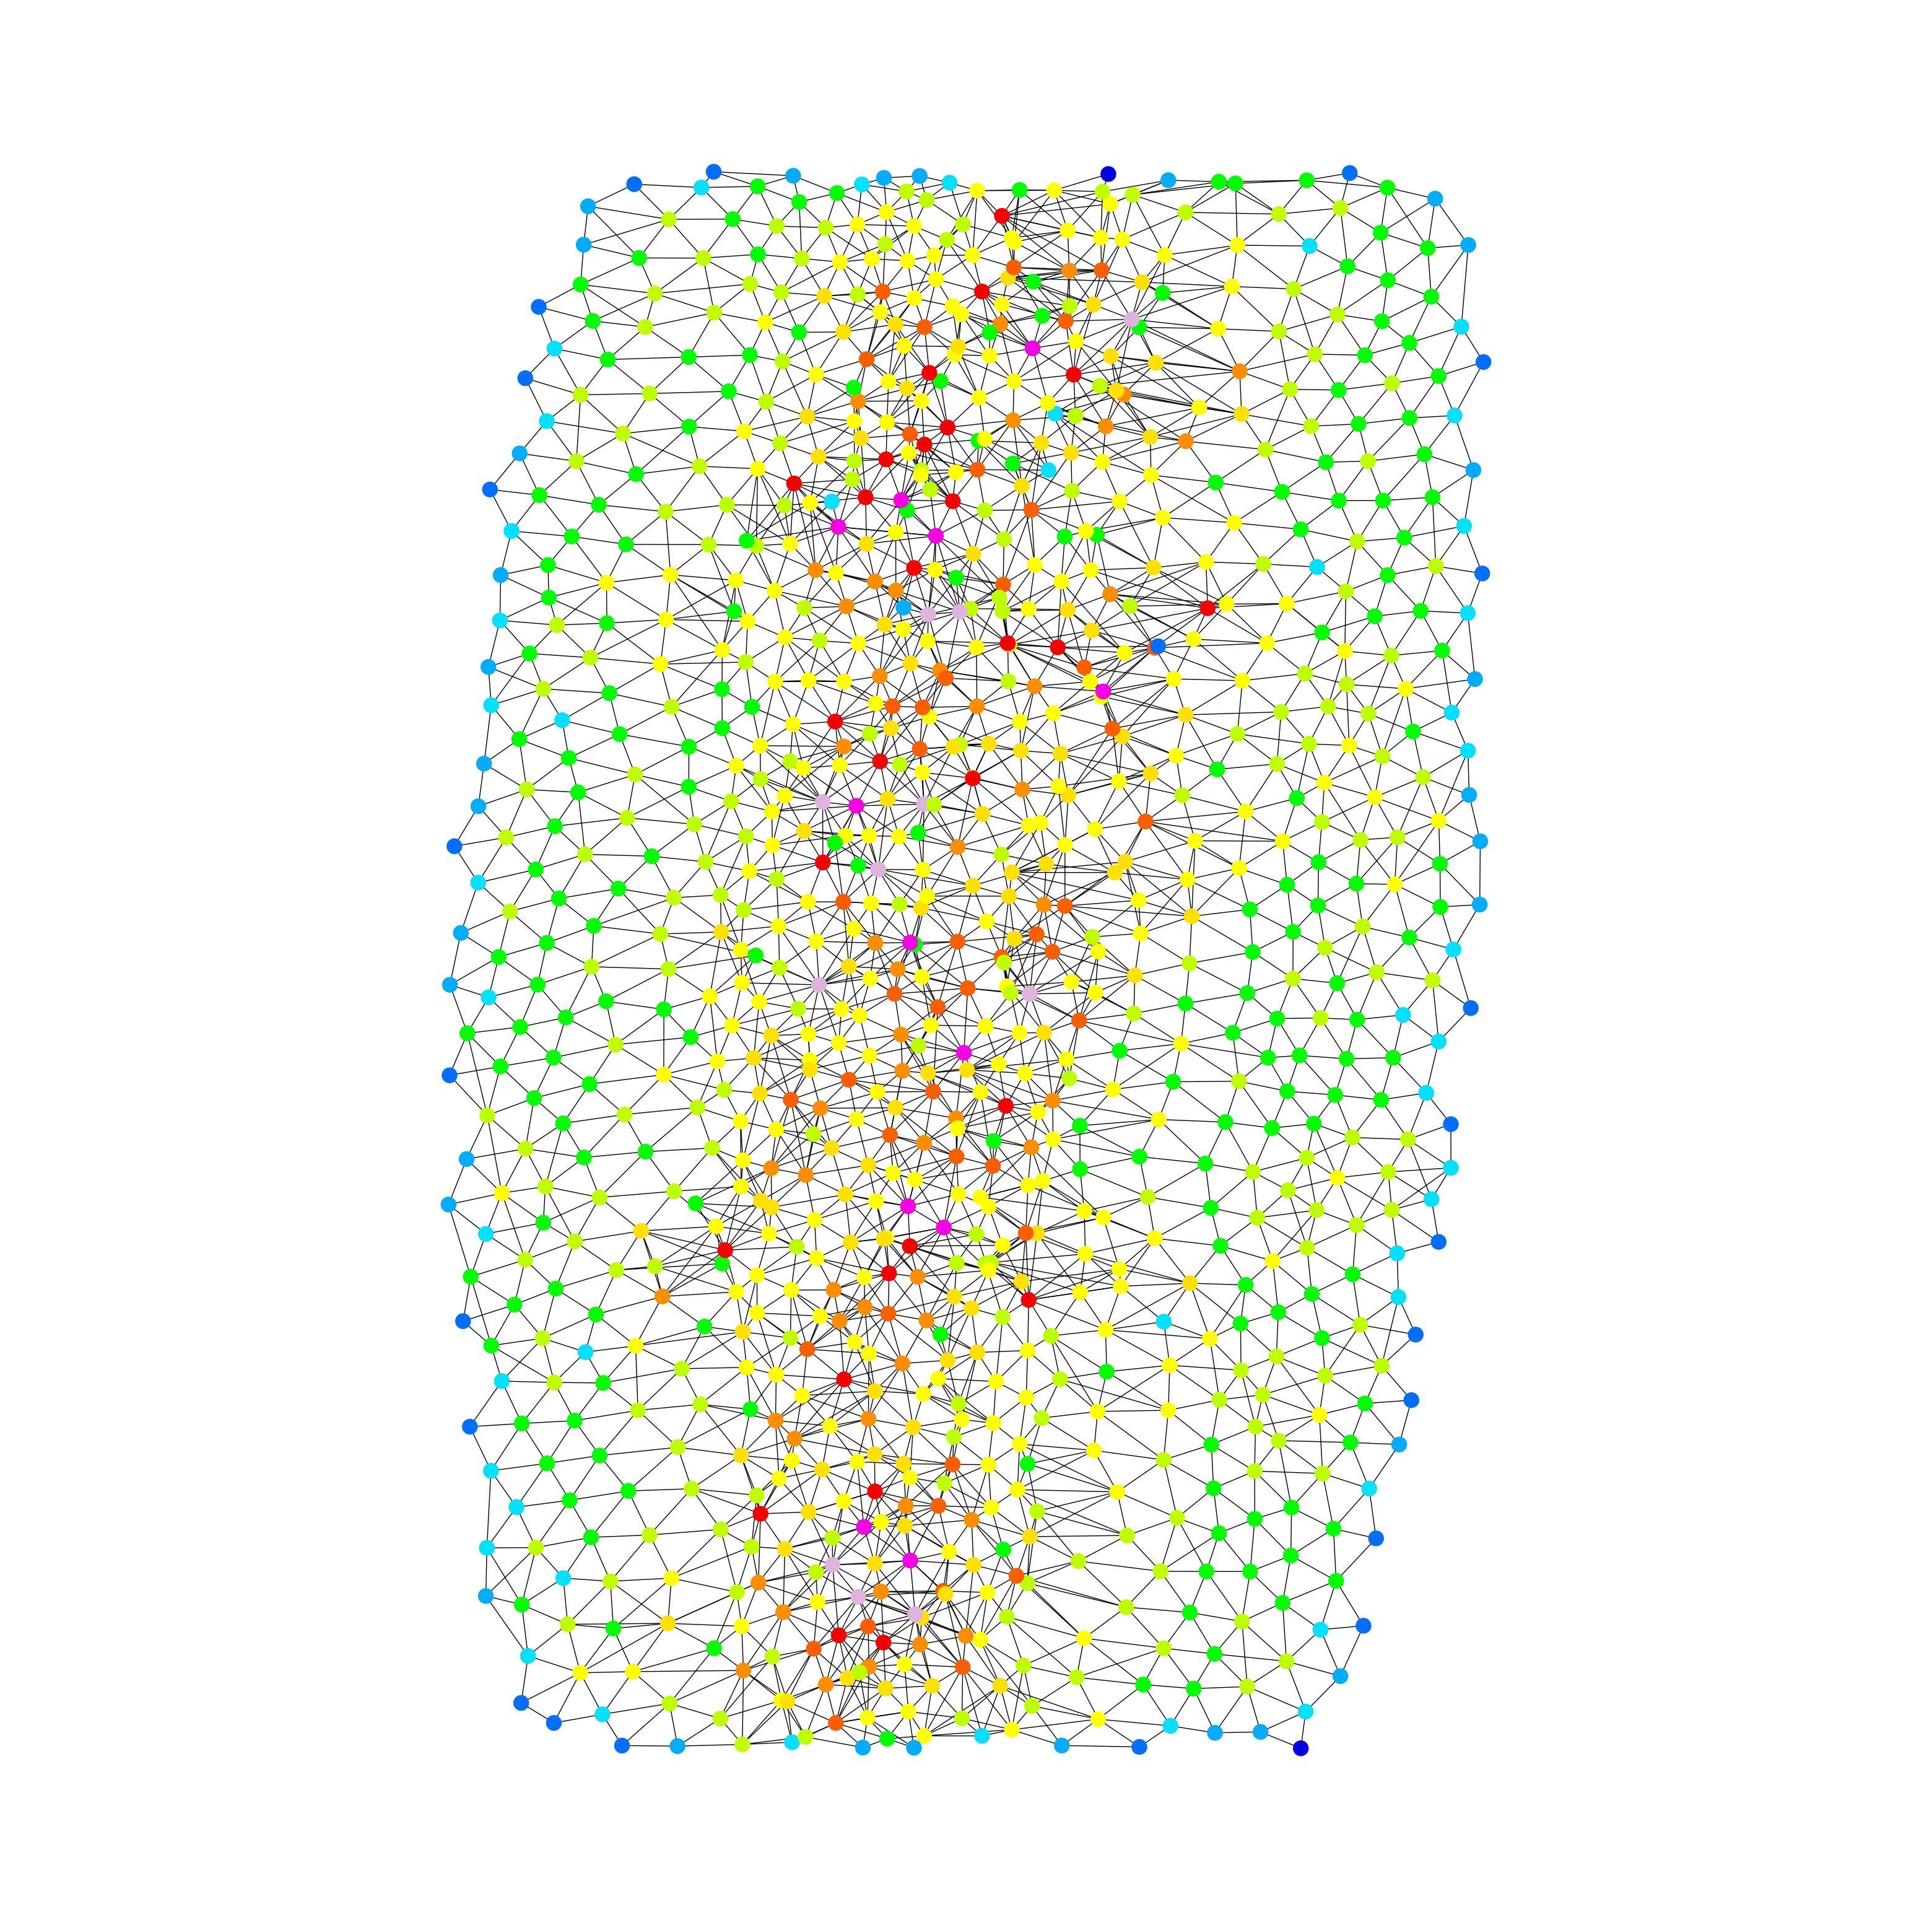

In [13]:
pos = nx.get_node_attributes(G,'pos')

color_map = [] 
for node in nx.get_node_attributes(G, "neighbor").values():
    if node == 1: 
        color_map.append('#0101ab')
    elif node == 2 :
        color_map.append('#0101e0')
    elif node == 3 :
        color_map.append('#006eff')
    elif node == 4 :
        color_map.append('#01abfe')
    elif node == 5 :
        color_map.append('#01e0fe')
    elif node == 6 :
        color_map.append('#01fe01')
    elif node == 7 :
        color_map.append('#beff00')
    elif node == 8 :
        color_map.append('yellow')
    elif node == 9 :
        color_map.append('#ffff00')
    elif node == 10 :
        color_map.append('#ffe000')
    elif node == 11 :
        color_map.append('#ff8d00')
    elif node == 12 :
        color_map.append('#fa5e00')
    elif node == 13 :
        color_map.append('#f50000')
    elif node == 14 :
        color_map.append('#f500e4')
    elif node >= 15 :
        color_map.append('#deb4de')
    
fig, ax = plt.subplots()
nx.draw(G, with_labels=False, node_color = color_map, pos=pos, ax=ax)
ax.axis("equal")
fig.set_size_inches((40,40))
fig.savefig(os.path.join(path, "network_color_coded.eps"))


In [10]:
np.max(cell_df["nb_neighbor"])

18

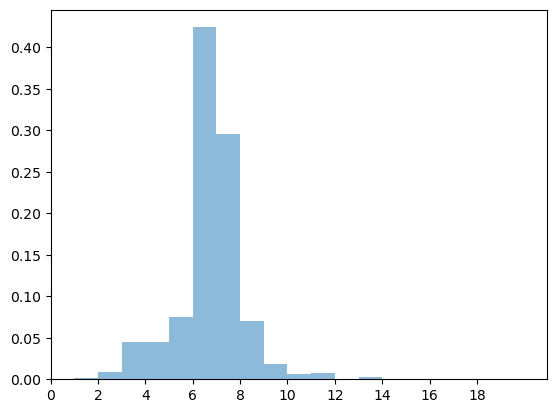

In [79]:
fig, ax = plt.subplots()
# ax.hist(cell_df_0["nb_neighbor"], range=(1,20), bins=19, alpha=0.5, density=True)
ax.hist(cell_df["nb_neighbor"], range=(1,20), bins=19, alpha=0.5, density=True)
# ax.set_xlim(0,20)
_=plt.xticks(np.arange(0, 20, step=2))
# fig.set_size_inches((20,10))

In [81]:
cell_df =  pd.read_csv(os.path.join("/mnt/sda1/Sophie/7-DosophilaEmbryo/T8/","cell_df.csv"), index_col=0)
cell_plane_df =  pd.read_csv(os.path.join("/mnt/sda1/Sophie/7-DosophilaEmbryo/T8/","cell_plane_df.csv"), index_col=0)

In [82]:
cell_df.sort_values("curv_ind")

id_im    x_center    y_center   z_center  nb_neighbor     volume  \
819    910  106.115632  436.586724  65.539615            3  61.124469   
875    981  335.644491  124.355509  70.498960            6  62.896193   
874    980   86.445977  108.560920  70.551724            4  56.399872   
872    977  366.960452   16.548023  70.621469            3  26.674285   
876    983  406.621723  424.608614  70.546816            4  69.589371   
..     ...         ...         ...        ...          ...        ...   
885    994   79.368421  228.556391  71.000000            3  18.799957   
886    996  352.442149  300.739669  71.000000            4  31.300453   
887    997   83.039604  312.594059  71.000000            3  15.059652   
888    998   84.047170  324.783019  71.000000            3  15.748655   
890   1003  114.644860  507.009346  71.000000            1  14.370648   

           area  real_dist  short_dist      curv_ind   orient_zy   orient_xy  \
819   94.650301   0.571211    0.571211 -2.220446e-16   90.485762  114.731084   
875   97.971364   0.697504    0.697504  0.000000e+00   73.191308  -71.746764   
874   83.856846   0.571156    0.571156  0.000000e+00   90.030971   94.398705   
872   56.458074   0.574419    0.574419  0.000000e+00   83.817070  -42.709390   
876  108.764820   0.579581    0.579581  0.000000e+00  102.859041  164.161118   
..          ...        ...         ...           ...         ...         ...   
885   24.077708   0.000000    0.000000           NaN    0.000000    0.000000   
886   31.550100   0.000000    0.000000           NaN    0.000000    0.000000   
887   21.586911   0.000000    0.000000           NaN    0.000000    0.000000   
888   22.417177   0.000000    0.000000           NaN    0.000000    0.000000   
890   16.190183   0.000000    0.000000           NaN    0.000000    0.000000   

     orient_xz     x_start     y_start  z_start       x_end       y_end  \
819   1.054522  105.620482  436.656627     65.0  105.638889  436.648148   
875 -42.487273  336.505208  124.197917     70.0  335.589286  124.500000   
874   0.402612   86.722973  108.540541     70.0   86.730000  108.540000   
872  -5.710593  367.300000   16.425000     70.0  367.200000   16.533333   
876   3.705506  406.189474  424.584211     70.0  406.254237  424.355932   
..         ...         ...         ...      ...         ...         ...   
885   0.000000   79.396040  228.792079     71.0   79.396040  228.792079   
886   0.000000  352.452632  300.868421     71.0  352.452632  300.868421   
887   0.000000   83.112676  312.957746     71.0   83.112676  312.957746   
888   0.000000   84.175676  324.824324     71.0   84.175676  324.824324   
890   0.000000  115.036585  507.487805     71.0  115.036585  507.487805   

     z_end  sphericity  
819   66.0    0.792816  
875   71.0    0.780671  
874   71.0    0.848134  
872   71.0    0.764692  
876   71.0    0.752242  
..     ...         ...  
885   71.0    1.420061  
886   71.0    1.522359  
887   71.0    1.366166  
888   71.0    1.355394  
890   71.0    1.765563  

[891 rows x 20 columns]

In [51]:
cell_plane_df[cell_plane_df["id_im"]==780]

id_im    x_center   y_center  z_center  x_center_um  y_center_um  \
25482  780.0  362.792593  70.629630      54.0   150.607141    29.320683   
25483  780.0  362.800000  70.320000      55.0   150.610216    29.192146   
25484  780.0  362.645833  69.812500      56.0   150.546216    28.981466   
25485  780.0  362.777778  69.666667      57.0   150.600991    28.920925   
25486  780.0  362.714286  69.142857      58.0   150.574633    28.703475   
25487  780.0  362.000000  68.500000      59.0   150.278110    28.436604   
25488  780.0  361.000000  69.000000      60.0   149.862977    28.644170   
25489  780.0  359.000000  69.000000      61.0   149.032711    28.644170   
25490  780.0  358.000000  70.000000      62.0   148.617578    29.059303   
25491  780.0  356.000000  70.000000      63.0   147.787312    29.059303   
25492  780.0  355.000000  70.000000      64.0   147.372180    29.059303   
25493  780.0  354.000000  71.000000      65.0   146.957047    29.474436   
25494  780.0  353.000000  71.000000      66.0   146.541914    29.474436   
25495  780.0  352.000000  71.000000      67.0   146.126781    29.474436   
25496  780.0  350.000000  72.000000      68.0   145.296515    29.889569   
25497  780.0  349.000000  73.000000      69.0   144.881382    30.304702   
25498  780.0  348.000000  73.000000      70.0   144.466249    30.304702   
25499  780.0  348.000000  72.000000      71.0   144.466249    29.889569   

       z_center_um     aniso  orientation_x  orientation_y      major  \
25482    30.842030  1.701259       0.960651       0.277758  27.657763   
25483    31.413179  1.446530       0.983938       0.178513  30.314779   
25484    31.984327  1.292071       0.990571       0.136998  36.486876   
25485    32.555476  1.253199       0.996951      -0.078034  38.598738   
25486    33.126625  1.164784       0.942401       0.334486  39.301800   
25487    33.697773  1.090242       0.231278       0.972888  37.711508   
25488    34.268922  1.159452      -0.531976       0.846759  40.694334   
25489    34.840071  1.258708      -0.595728       0.803187  40.696526   
25490    35.411219  1.498244       0.352723      -0.935728  51.180849   
25491    35.982368  1.374443       0.640499      -0.767959  37.205593   
25492    36.553517  1.357706      -0.559378       0.828913  35.450544   
25493    37.124665  1.349986      -0.516162       0.856491  32.478858   
25494    37.695814  1.277379      -0.405949       0.913896  30.413967   
25495    38.266963  1.294702      -0.592899       0.805277  30.722626   
25496    38.838112  1.271958      -0.543251       0.839570  31.022182   
25497    39.409260  1.215560      -0.588479       0.808513  27.657515   
25498    39.980409  1.251905      -0.595962       0.803013  29.695001   
25499    40.551558  1.270726       0.731581      -0.681754  29.872088   

           minor   area  perimeter  nb_neighbor  
25482  16.257233  163.0  50.332823          4.0  
25483  20.956891  198.5  54.417536          4.0  
25484  28.239063  257.0  60.123264          4.0  
25485  30.800156  277.0  62.519401          4.0  
25486  33.741719  293.5  63.584245          5.0  
25487  34.590028  290.5  63.318258          5.0  
25488  35.097900  304.5  64.879586          5.0  
25489  32.331972  303.5  66.232481          5.0  
25490  34.160556  345.0  70.858237          5.0  
25491  27.069588  256.0  61.439898          6.0  
25492  26.110614  241.0  58.670364          6.0  
25493  24.058655  223.5  56.970177          6.0  
25494  23.809658  214.0  55.935260          6.0  
25495  23.729498  217.0  55.804679          6.0  
25496  24.389318  220.0  55.400865          6.0  
25497  22.752898  200.0  52.863600          6.0  
25498  23.719849  210.5  53.773873          6.0  
25499  23.507888  211.5  54.683109          7.0

In [53]:
image_colored = colored_image_cell(image, cell_df, "curv_ind", normalize=False)

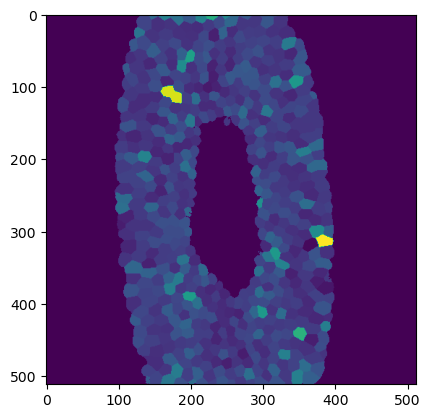

In [54]:
plt.imshow(image_colored[50])

In [55]:
write_tiff(image_colored, "curv_ind", path, pixel_size, _type="float32")

In [16]:
image_skeleton = create_skeleton(seg)

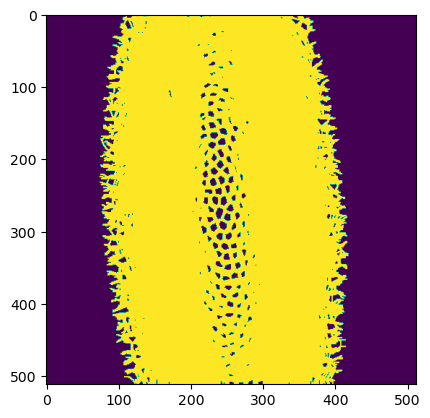

In [17]:
plt.imshow(image_skeleton.max(axis=0))

In [18]:
write_tiff(image_skeleton, "skeleton", path, pixel_size, _type="uint8")

id_im_1  id_im_2  edge_1  edge_2      x      y     z
0            1.0     10.0     0.0     1.0  241.0  216.0   6.0
1            1.0     10.0     0.0     1.0  242.0  216.0   6.0
2            1.0     10.0     0.0     1.0  243.0  216.0   6.0
3            1.0     10.0     0.0     1.0  242.0  217.0   6.0
4            1.0     10.0     0.0     1.0  243.0  217.0   6.0
...          ...      ...     ...     ...    ...    ...   ...
5734133   1000.0    761.0  6125.0  6127.0  133.0  368.0  71.0
5734134   1000.0    761.0  6125.0  6127.0  132.0  369.0  71.0
5734135   1000.0    761.0  6125.0  6127.0  133.0  369.0  71.0
5734136   1000.0    761.0  6125.0  6127.0  132.0  370.0  71.0
5734137   1000.0    761.0  6125.0  6127.0  133.0  370.0  71.0

[5734138 rows x 7 columns]